In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3
import pdb
import os

%matplotlib inline
import matplotlib.pyplot as plt

In [39]:
inpatient_df = pd.read_csv('idea-1/medicare-data/medicare-data/Inpatient_provdr.csv')
outpatient_df = pd.read_csv('idea-1/medicare-data/medicare-data/Outpatient_provdr.csv')

In [35]:
conn = sqlite3.connect('hospital_charges.db')
_df = pd.read_csv('idea-1/medicare-data/medicare-data/Inpatient_provdr.csv')
_df.columns = [column.strip() for column in _df.columns] #returns an object with all the columns names
#for column in ['Average Covered Charges', 'Average Total Payments', 'Average Medicare Payments']:
    #_df[column] = _df[column].map(lambda x: x[1:])
    #_df[column] = pd.to_numeric(_df[column])
_df.to_sql('hospital_charges', conn, if_exists='replace', index=False)
conn.close()

In [36]:
conn = sqlite3.connect('hospital_charges.db')

query = '''
SELECT `DRG Definition`, `Provider State` as providerState, t.maxAvgPaymentPerDRG
FROM hospital_charges hc
INNER JOIN (
    SELECT `DRG Definition` as drg, MAX(`Average Total Payments`) as maxAvgPaymentPerDRG
    FROM hospital_charges
    GROUP BY `DRG Definition`
) t
ON hc.`DRG Definition` == t.drg AND hc.`Average Total Payments` == t.maxAvgPaymentPerDRG
ORDER BY providerState ASC
'''

cursor = conn.execute(query)
results = [record for record in cursor]
conn.close()

In [37]:
_df = pd.DataFrame(results, columns=['DRG', 'ProviderState', 'Payment'])

In [40]:
conn = sqlite3.connect('hospital_charges.db')

ranking_by_drg = dict()
for drg in inpatient_df['DRG Definition'].unique():

    query = """
        SELECT `Provider State` as providerState
        FROM hospital_charges
        WHERE `DRG Definition` = '{drg}' 
        GROUP BY `Provider State`
        ORDER BY AVG(`Average Total Payments`) ASC
    """.format(drg=drg)
    
    cursor = conn.execute(query)
    ranking_by_drg[drg] = [record[0] for record in cursor]
    
conn.close()

In [41]:
for k,v in ranking_by_drg.items():
    while True:
        if len(v) >= 51:
            break
        v.append(None)

In [42]:
drg_by_id = {key.split(' - ')[0]: key for key in ranking_by_drg.keys()}
df_rank = pd.DataFrame(ranking_by_drg)

In [44]:
from collections import defaultdict

_df = pd.DataFrame(index=inpatient_df['Provider State'].unique())
for column in df_rank.columns:
    rankings_by_state = []

    if column in ['rank']:
        continue
        
    for rank, curr_state in zip(inpatient_df.index, df_rank[column]):
        rankings_by_state.append(curr_state)
    
    t = pd.DataFrame(rankings_by_state, columns=['State'])
    t['Rank'] = t.index
    t.set_index(['State'], inplace=True)
    
    _df = pd.merge(left=_df, right=t, how='left', left_index=True, right_index=True)
    
_df.columns = drg_by_id.keys()

C:\Users\alexa\AppData\Local\Temp\ipykernel_19684\1404917191.py:17: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Rank_x'} in the result is deprecated and will raise a MergeError in a future version.
  _df = pd.merge(left=_df, right=t, how='left', left_index=True, right_index=True)
C:\Users\alexa\AppData\Local\Temp\ipykernel_19684\1404917191.py:17: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Rank_x'} in the result is deprecated and will raise a MergeError in a future version.
  _df = pd.merge(left=_df, right=t, how='left', left_index=True, right_index=True)
C:\Users\alexa\AppData\Local\Temp\ipykernel_19684\1404917191.py:17: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Rank_x'} in the result is deprecated and will raise a MergeError in a future version.
  _df = pd.merge(left=_df, right=t, how='left', left_index=True, right_index=True)
C:\Users\alexa\AppData\Local\Temp\ipykernel_19684\1404917191.py:17: FutureWarning: Passing 

In [45]:
_df.fillna(-100, inplace=True)
_df.head() #wherre -100 is not a rank but only a placeholder - shown as dark blue in the heatmap

,039,057,064,065,066,069,074,101,149,176,...,812,853,870,871,872,885,897,917,918,948
AK,45,46,50,50,50,49.0,-100.0,49,-100.0,49,...,50,49,47.0,50,50,48.0,48,-100.0,49,50
AL,0,0,1,1,0,0.0,2.0,0,2.0,0,...,0,1,1.0,1,1,1.0,0,2.0,1,0
AR,3,4,3,2,2,1.0,5.0,3,1.0,1,...,3,0,0.0,0,2,2.0,1,6.0,0,1
AZ,36,29,33,33,34,36.0,22.0,34,27.0,35,...,36,25,25.0,38,37,34.0,8,23.0,27,28
CA,44,44,47,45,46,44.0,44.0,44,40.0,45,...,46,46,45.0,45,45,44.0,46,44.0,44,44


Text(0.5, 418.0199999999999, 'DRG Definition Id')

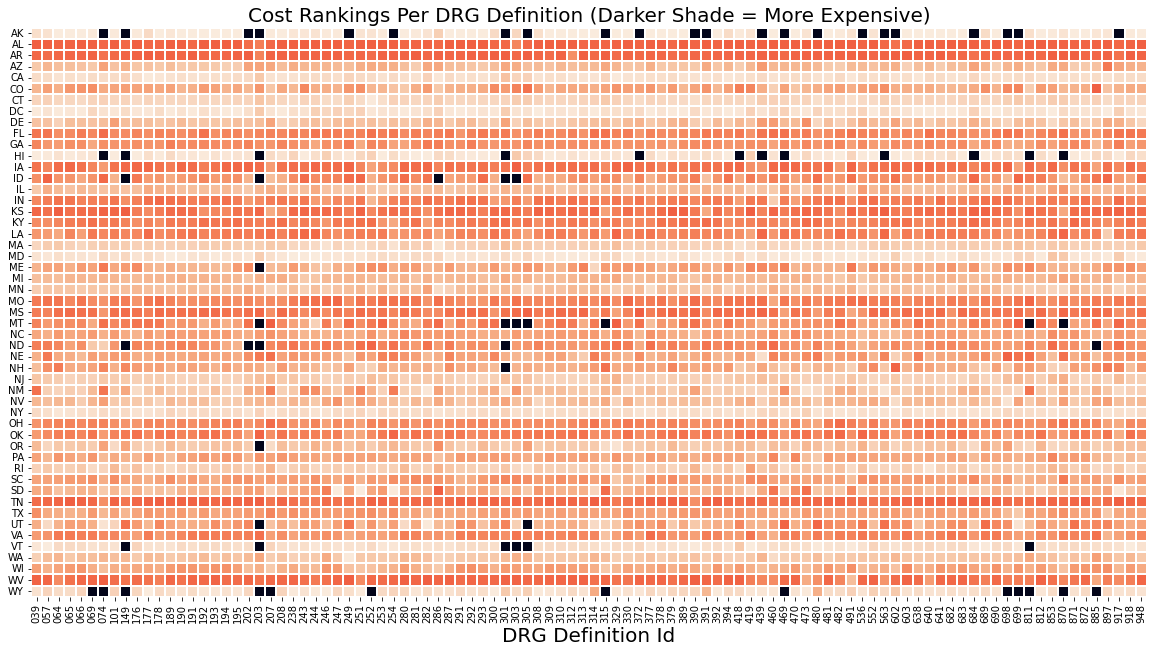

In [46]:
plt.figure(figsize=(20,20))
sns.heatmap(_df, square=True, vmin=-100, cbar=False, linewidths=0.1)
plt.title("Cost Rankings Per DRG Definition (Darker Shade = More Expensive)", fontsize=20)
plt.xlabel("DRG Definition Id", fontsize=20)